**请关注我的知乎专栏[https://zhuanlan.zhihu.com/hawkcp], 获取更多信息**

这里展示的信息对应于专栏文章：18. 纹理合成再探 - 一种基于金字塔的方法

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as transform
from skimage.exposure import cumulative_distribution
# from perceptual.filterbank import Steerable, visualize

%matplotlib inline

直方图匹配的一种Python实现，相关代码源自StackOverflow，但输入类型限制为了8位的单通道整型数据。

In [2]:
def cdf(im):
 '''
 computes the CDF of an image im as 2D numpy ndarray
 '''
 c, b = cumulative_distribution(im) 
 # pad the beginning and ending pixels and their CDF values
 c = np.insert(c, 0, [0]*b[0])
 c = np.append(c, [1]*(255-b[-1]))
 return c

def hist_matching(c, c_t, im):
 '''
 c: CDF of input image computed with the function cdf()
 c_t: CDF of template image computed with the function cdf()
 im: input image as 2D numpy ndarray
 returns the modified pixel values
 ''' 
 pixels = np.arange(256)
 # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of   
 # the template image at the corresponding pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
 new_pixels = np.interp(c, c_t, pixels) 
 im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
 return im

def matchHist(img1, imgP):
    cdf1=cdf(img1)
    cdfP=cdf(imgP)
    out = hist_matching(cdf1, cdfP, img1)
    return out


直方图匹配的另外一种Python实现，相关代码源自StackOverflow，输入类型可以支持浮点型。

In [4]:
def matchHist2(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

展示了直方图匹配的结果

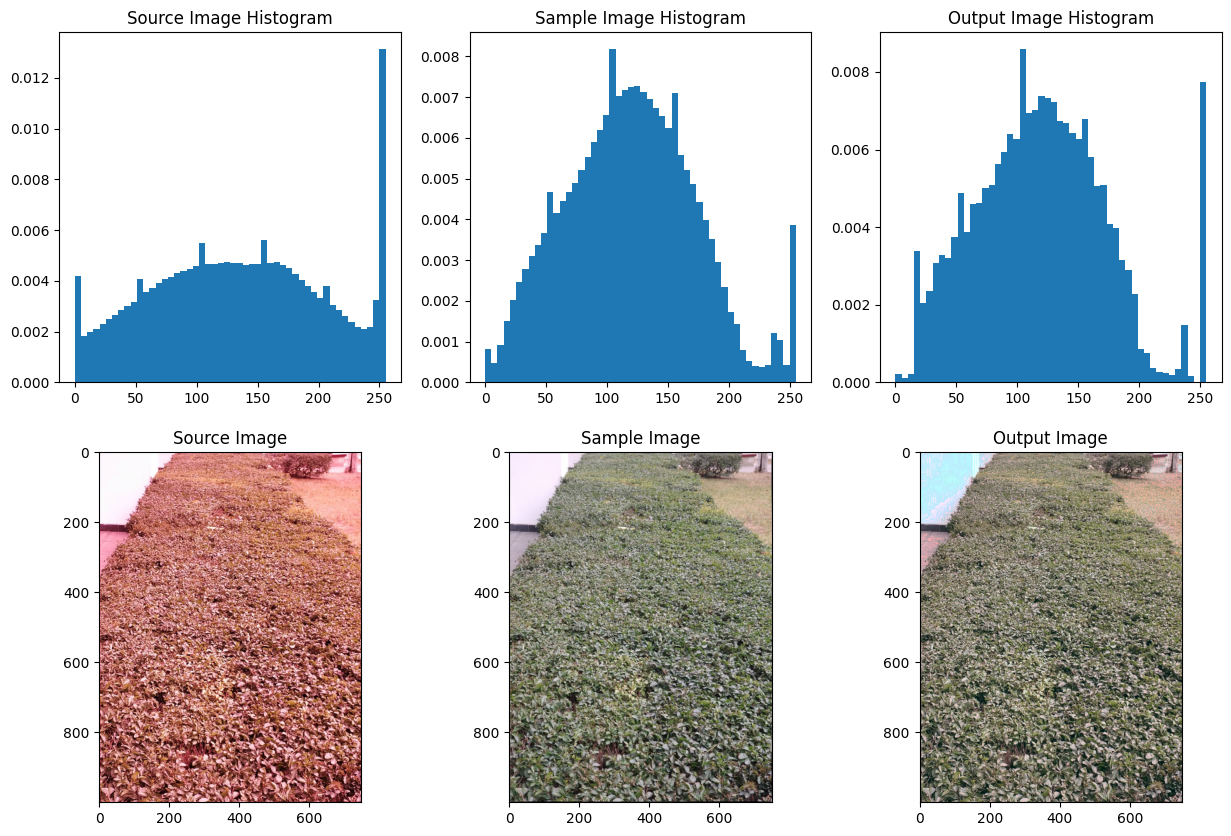

In [5]:
img2=cv2.imread("./images/main1.jpg")[:,:,2::-1]
img1=cv2.imread("./images/aux1.jpg")[:,:,2::-1]
imgo=img1.copy()
for c in range(3):
    imgo[:,:,c]=matchHist2(img1[:,:,c], img2[:,:,c])
    
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.title("Source Image Histogram")
plt.hist(img1.flatten(),histtype="stepfilled",bins=50,density=True)
plt.subplot(2,3,2)
plt.title("Sample Image Histogram")
plt.hist(img2.flatten(),histtype="stepfilled",bins=50,density=True)
plt.subplot(2,3,3)
plt.title("Output Image Histogram")
plt.hist(imgo.flatten(),histtype="stepfilled",bins=50,density=True)
plt.subplot(2,3,4)
plt.imshow(img1, cmap="gray")
plt.title("Source Image")
plt.subplot(2,3,5)
plt.imshow(img2,cmap="gray")
plt.title("Sample Image")
plt.subplot(2,3,6)
plt.imshow(imgo, cmap="gray")
plt.title("Output Image")

plt.show()


stitchImg=np.zeros([img2.shape[0], img2.shape[1]*3, 3], np.uint8)

stitchImg[:,0:img2.shape[1]]=img2
stitchImg[:,img2.shape[1]:img2.shape[1]+img1.shape[1]]=img1
stitchImg[:,img2.shape[1]*2:img2.shape[1]*3]=imgo
_=cv2.imwrite("./images/imgo.jpg", imgo[:,:,2::-1])
_=cv2.imwrite("./images/stitchImg.jpg", stitchImg[:,:,2::-1])

In [2]:
from steerable.SCFpyr_NumPy import SCFpyr_NumPy   # steerable 库地址 https://github.com/tomrunia/PyTorchSteerablePyramid 但是针对scipy和numpy有固定的版本要求
import steerable.utils as utils


#读入纹理片段
texture=cv2.imread('./images/texture.png')[0:680,0:680]
textureYIQ=cv2.cvtColor(texture, cv2.COLOR_BGR2YCrCb)

#构造噪声图像
noise=np.random.randint(0,255,size=(textureYIQ.shape[0],textureYIQ.shape[1],3)).astype(np.uint8)
noiseYIQ=cv2.cvtColor(noise, cv2.COLOR_BGR2YCrCb)



基于金字塔的纹理图像合成方法

In [13]:
def matchTexture(noise, texture):
    outputImg = matchHist2(noise, texture)
    totalLayer=7
    
    pyr = SCFpyr_NumPy(
        height=totalLayer,
        nbands=4,
        scale_factor=2,
    )
    pyrTexture=pyr.build(texture)
    for iter in range(10):
        pyrNoise = pyr.build(outputImg)
        for layer in range(0,totalLayer):
            if layer==0 or layer==totalLayer-1 :
                pyrNoise[layer]=matchHist2(pyrNoise[layer], pyrTexture[layer])
            else:
                for sublayer in range(len(pyrNoise[layer])):
                    pyrNoise[layer][sublayer].real=matchHist2(pyrNoise[layer][sublayer].real, pyrTexture[layer][sublayer].real)

        outputImg = pyr.reconstruct(pyrNoise)
        outputImg2 = matchHist2(outputImg, texture)
        return outputImg2

合成纹理的过程

In [14]:
imgoYIQ = noiseYIQ.copy()
for c in range(3):
    imgoYIQ[:,:,c] = matchTexture(noiseYIQ[:,:,c], textureYIQ[:,:,c])
    
imgo = cv2.cvtColor(imgoYIQ,cv2.COLOR_YCrCb2BGR)
_=cv2.imwrite("./images/synthesisImg.jpg", imgo)

下面展示的结果说明我还没有完全复现论文中的基本结果，应该需要再看看有没有什么特殊的设置不对，例如Steerable 金字塔的配置

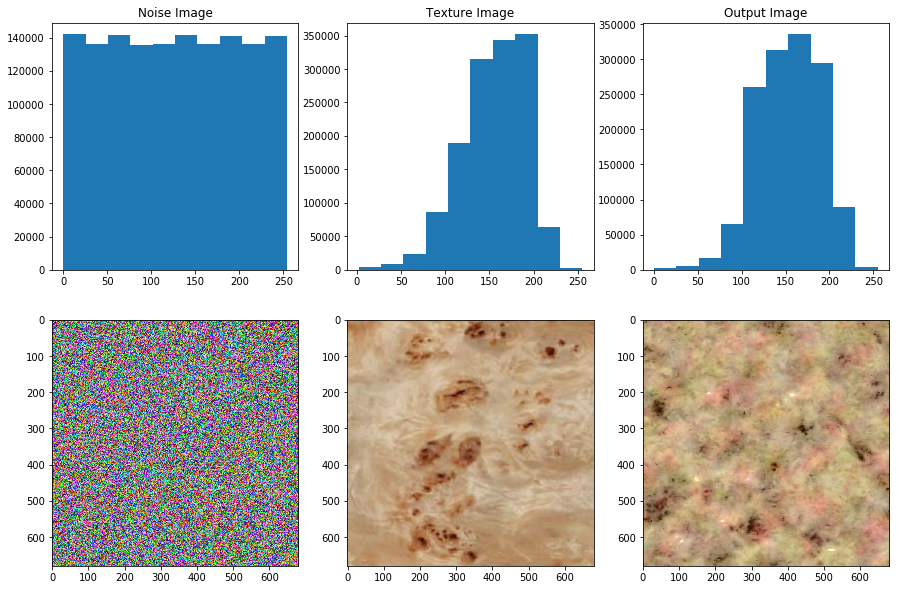

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.title("Noise Image")
plt.hist(noise.flatten())
plt.subplot(2,3,2)
plt.title("Texture Image")
plt.hist(texture.flatten())
plt.subplot(2,3,3)
plt.title("Output Image")
plt.hist(imgo.flatten())
plt.subplot(2,3,4)
plt.imshow(noise[:,:,2::-1], cmap="gray")
plt.subplot(2,3,5)
plt.imshow(texture[:,:,2::-1],cmap="gray")
plt.subplot(2,3,6)
plt.imshow(imgo[:,:,2::-1], cmap="gray")

plt.show()